In [2]:
import pandas
import matplotlib.pyplot as plt
import os
import random
import itertools
import numpy as np
from scipy.ndimage import uniform_filter1d
from ray import train, tune

c:\Users\Mikael\miniconda3\envs\tikkiAI\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-07 20:59:36,011	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-07 20:59:37,106	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [43]:
#filename = os.path.join("results","PPO_bestagaincont_hid90_rolls5_nups1_actlr5e-05_critlr9e-06"  + ".csv")
#filename = os.path.join("results","PPO_gridTest2_hid90_rolls5_nups1_actlr0.0001_critlr6e-05_again"  + ".csv")
filename = os.path.join("results","PPO_model4_test5_hid90_rolls5_nups3_actlr0.0001_critlr5e-05"  + ".csv")

data = pandas.read_csv(filename)
plt.plot(data['winrates'])
plt.plot(data['winrates'].rolling(50).mean())
plt.ylabel('Winrate')
plt.xlabel('Episode')
#plt.ylim([0.5,0.8])
print(f"Max winrate: {data['winrates'][-10000:].mean()}")
len(data['winrates'])
test = data['winrates'].rolling(50).mean()

FileNotFoundError: [Errno 2] No such file or directory: 'results\\PPO_model4_test5_hid90_rolls5_nups3_actlr0.0001_critlr5e-05.csv'

Max winrate: 0.66793775


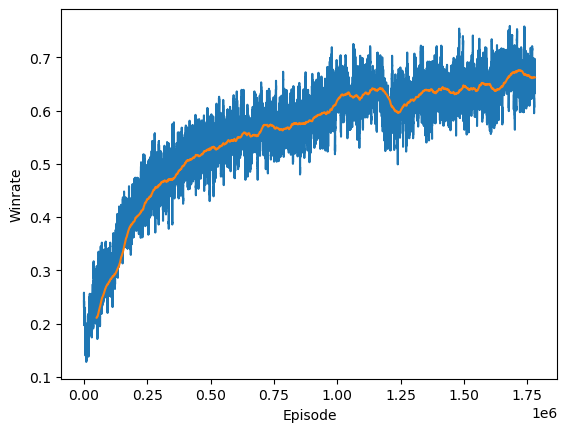

In [4]:
filename = os.path.join("results","PPO_gridTest2_hid90_rolls5_nups1_actlr0.0001_critlr6e-05_again"  + ".csv")
filename2 = os.path.join("results","PPO_gridTest2_hid90_rolls5_nups1_actlr0.0001_critlr6e-05_again_cont"  + ".csv")
data = pandas.read_csv(filename)
data2 = pandas.read_csv(filename2)
data = pandas.concat((data,data2),axis=0)
data.reset_index()

plt.plot(list(range(data.shape[0])),data['winrates'])
plt.plot(list(range(data.shape[0])),data['winrates'].rolling(50000).mean())
plt.ylabel('Winrate')
plt.xlabel('Episode')
#plt.ylim([0.5,0.8])
print(f"Max winrate: {data['winrates'][-100000:].mean()}")

In [8]:
hidden_size = [90]
n_rollouts = [5]
n_updates_per_iter = [1]
actor_lr = [1e-4,8e-5,5e-5]
critic_lr = [6e-5,3e-5,9e-6]

# Compute cartesian product of parameter grids
all_combinations = list(itertools.product(
    hidden_size, n_rollouts, n_updates_per_iter, actor_lr, critic_lr
))
random.shuffle(all_combinations)
for combo in all_combinations:
    identifier = f"actor_PPO_bestagaincont_hid{combo[0]}_rolls{combo[1]}_nups{combo[2]}_actlr{combo[3]}_critlr{combo[4]}"  # Generates identifier based on the combination
    filename_wins = os.path.join("results",identifier  + ".csv")
    filename_model = os.path.join("model",identifier  + ".pth")
    if os.path.isfile(filename_wins) :#and os.path.isfile(filename_model):
        data = pandas.read_csv(filename_wins)
        plt.plot(data['winrates'])
        plt.plot(data['winrates'].rolling(50000).mean())
        plt.ylabel('Winrate')
        plt.xlabel('Episode')
        #plt.ylim([0.5,0.8])
        print(f"{identifier}")
        print(f"Winrate: {data['winrates'][-50000:].mean()}")
        plt.show()
    

In [ ]:
experiment_path = os.path.join("D:/Python/Tikki/ray_tuner/tuning4")
print(f"Loading results from {experiment_path}...")

def run_agent_simulation(config):  
    identifier=""
    round_n=5
    card_n=5
    bet_n=3
    player_n=2
    GAMMA=0.97
    hidden_size=config["hid"]
    lr_actor = config["a_lr"]
    lr_critic = config["c_lr"]
    n_rollouts = config["rols"]
    n_updates_per_iter = config["nups"]
    EPS_N=50000
    agent_name=None
    opt_state_dict=None
    scheduler_lmbd=config["lmbd"]

    global winners, times
    winners = []
    start1 = time.time()
    n_inputs = card_n + player_n*(1+round_n) + player_n 
    n_outputs = 52+bet_n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = "cpu"
    print(f"Device: {device}")
    play_device = "cpu"
    # Load net
    Actor = myModel.Actor(n_inputs,hidden_size,n_outputs).to(play_device)
    Critic = myModel.Critic(n_inputs,hidden_size).to(play_device)
    if agent_name:
        Actor.load_state_dict(torch.load(os.path.join('./model',f"Actor_{agent_name}.pth")))
        Critic.load_state_dict(torch.load(os.path.join('./model',f"Critic_{agent_name}.pth")))
    
    # Uncomment if using scheduler
    # scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99999)

    # Load enemy
    enemy_net = model.Actor(n_inputs, 90, n_outputs)
    model_folder_path = "D:/Python/Tikki/model/"
    #model_name = "PPO_tests_model2_6.pth"
    model_name = "actor_PPO_gridTest2_hid90_rolls5_nups1_actlr0.0001_critlr6e-05_again.pth"
    file_name = os.path.join(model_folder_path, model_name)
    enemy_net.load_state_dict(torch.load(file_name))
    enemy = AI("XXX_SLAYAH_XXX",enemy_net,play_device)
    # Set optimizers
    actor_optim = optim.Adam(Actor.parameters(),lr=lr_actor)
    critic_optim = optim.Adam(Critic.parameters(),lr=lr_critic)
    # Define learning rate schedulers
    # Define the schedulers
    actor_scheduler = lr_scheduler.LinearLR(actor_optim, start_factor=1.0, end_factor=scheduler_lmbd, total_iters=EPS_N)
    critic_scheduler = lr_scheduler.LinearLR(critic_optim, start_factor=1.0, end_factor=scheduler_lmbd, total_iters=EPS_N)

    #opt_file_path = os.path.join(model_folder_path,f"optimizers_{identifier}")
    if opt_state_dict:
        load_opt_state = torch.load(os.path.join(model_folder_path,opt_state_dict))
        actor_optim.load_state_dict(load_opt_state['Actor_opt_state_dict'])
        critic_optim.load_state_dict(load_opt_state['Critic_opt_state_dict'])
        for act_param_group,crit_param_group in zip(actor_optim.param_groups,critic_optim.param_groups):
            act_param_group['lr'] = lr_actor
            crit_param_group['lr'] = lr_critic

    start = time.time()
    EPS_N_normed = int(EPS_N/n_rollouts)
    ME = Agent(identifier,EPS_N_normed,Actor,Critic,device,play_device,actor_optim,critic_optim,actor_scheduler,critic_scheduler,GAMMA,enemy,n_rollouts,n_updates_per_iter)
    policy_net = ME.learn()
    print(f"Duration: {time.time()-start1}\n\n")

restored_tuner = tune.Tuner.restore(experiment_path,trainable=run_agent_simulation)
result_grid = restored_tuner.get_results()
result_grid

Loading results from D:/Python/Tikki/ray_tuner/tuning4...


Results: 143


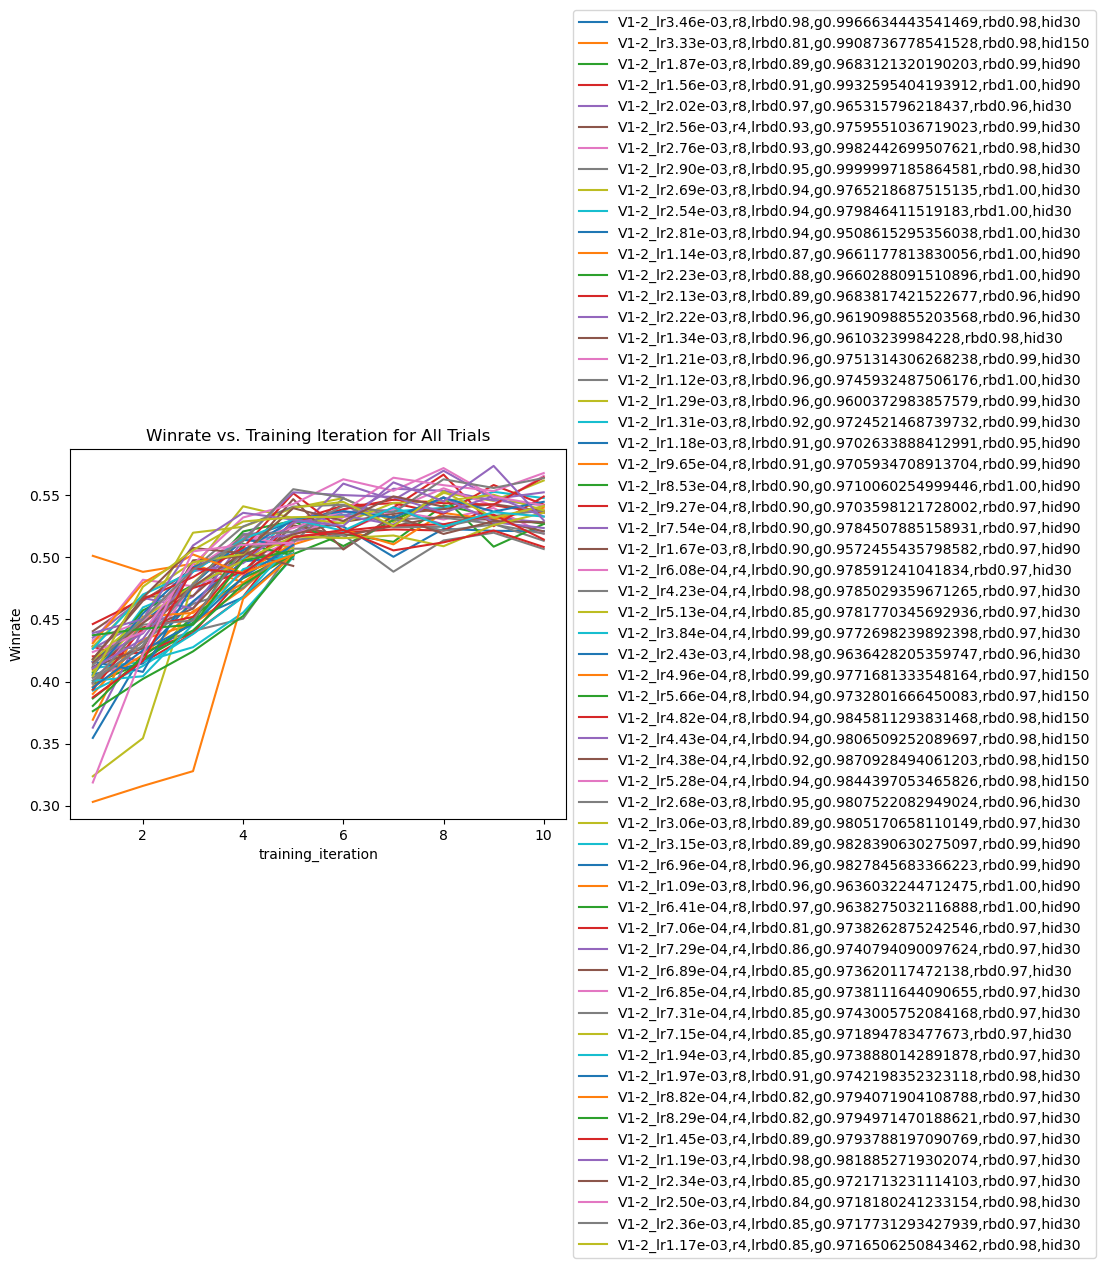

In [22]:
ax = None
print(f"Results: {len(result_grid)}")
for result in result_grid:
    if result.config is not None:
        label =f"V1-2_lr{result.config['lr']:.2e},r{result.config['r']},lrbd{result.config['lrbd']:.2f},g{result.config['g']},rbd{result.config['rbd']:.2f},hid{result.config['hid']}"
        if result.metrics_dataframe.winrate.tail(3).max() > 0.5:
            if ax is None:
                ax = result.metrics_dataframe.plot("training_iteration", "winrate", label=label)
            else:
                result.metrics_dataframe.plot("training_iteration", "winrate", ax=ax, label=label)
ax.set_title("Winrate vs. Training Iteration for All Trials")
ax.set_ylabel("Winrate")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

PPO_model4_test9_hid30_rolls5_nups1_actlr0.0001_critlr5e-05
Winrate: 0.5478911


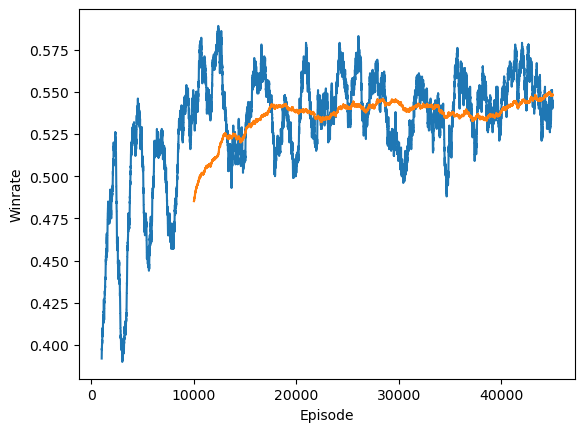

PPO_model4_test9_hid30_rolls5_nups5_actlr0.0001_critlr5e-05
Winrate: 0.5589805


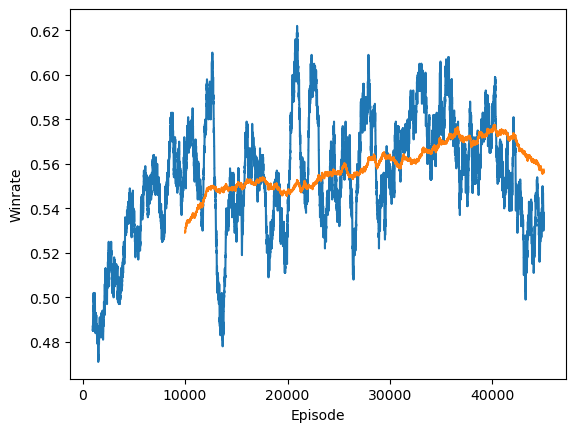

PPO_model4_test9_hid30_rolls10_nups1_actlr0.0001_critlr5e-05
Winrate: 0.4107884


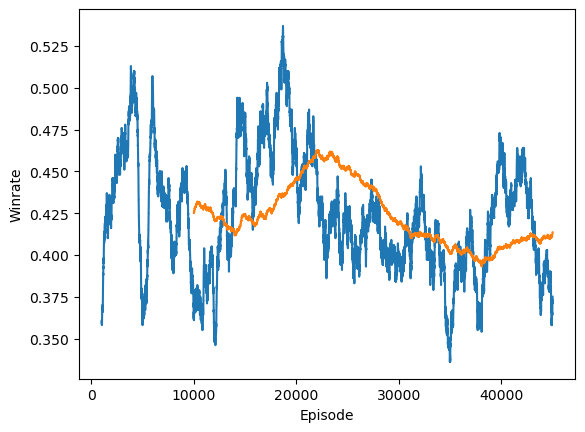

PPO_model4_test9_hid30_rolls10_nups5_actlr0.0001_critlr5e-05
Winrate: 0.5689666


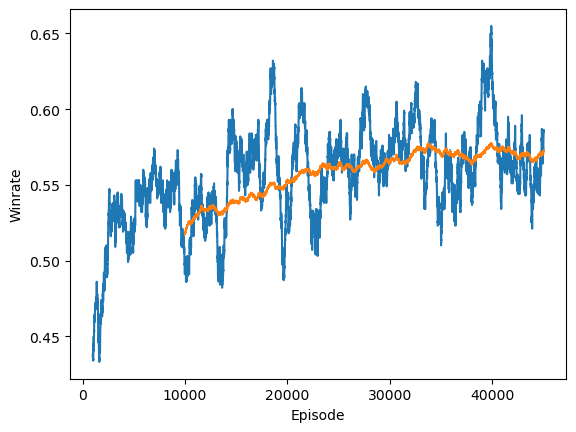

PPO_model4_test9_hid60_rolls5_nups1_actlr0.0001_critlr5e-05
Winrate: 0.5838515


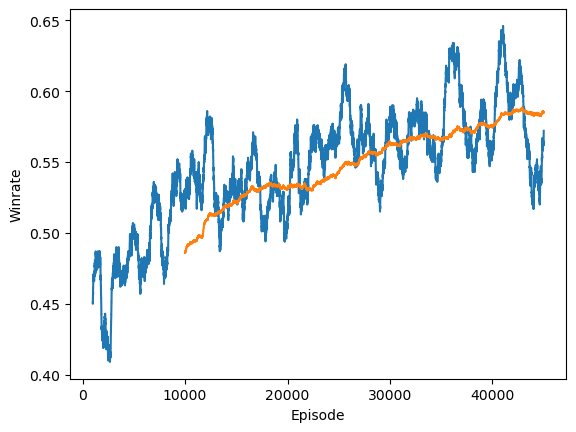

PPO_model4_test9_hid60_rolls5_nups5_actlr0.0001_critlr5e-05
Winrate: 0.5516274


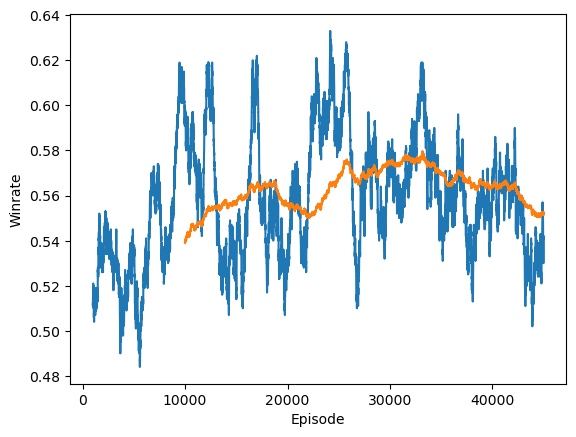

PPO_model4_test9_hid60_rolls10_nups1_actlr0.0001_critlr5e-05
Winrate: 0.5477645999999999


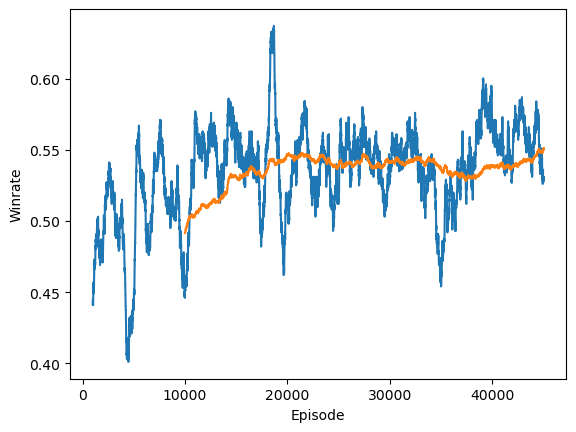

PPO_model4_test9_hid60_rolls10_nups5_actlr0.0001_critlr5e-05
Winrate: 0.4720173


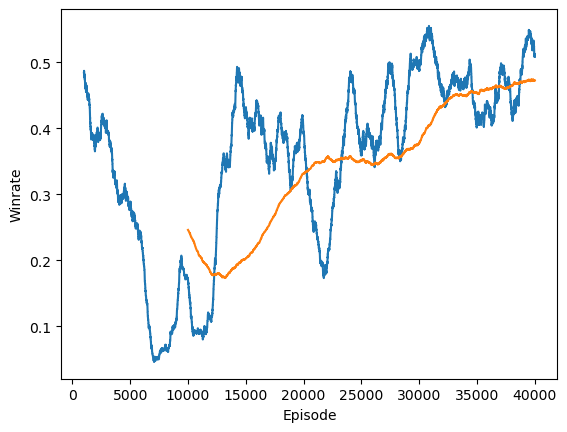

In [36]:
hidden_size = [30,60]#[90,30]
n_rollouts = [5,10]
n_updates_per_iter = [1,5]#[1,2,3]
actor_lr = [1e-4]#[5e-5,1e-4,5e-4]
critic_lr = [5e-5]#[1e-5,5e-5,1e-4]
#agent_name = ["PPO_gridTest2_hid90_rolls5_nups1_actlr0.0001_critlr6e-05_again_cont"]
#opt_state_dict= ["optimizers_PPO_gridTest2_hid90_rolls5_nups1_actlr0.0001_critlr6e-05_again_cont"]
agent_name = None
opt_state_dict = None

# Compute cartesian product of parameter grids
all_combinations = list(itertools.product(
    hidden_size, n_rollouts, n_updates_per_iter, actor_lr, critic_lr, #agent_name, opt_state_dict
))

for combo in all_combinations:
    identifier = f"PPO_model4_test9_hid{combo[0]}_rolls{combo[1]}_nups{combo[2]}_actlr{combo[3]}_critlr{combo[4]}"  # Generates identifier based on the combination
    filename_wins = os.path.join("results",identifier  + ".csv")
    filename_model = os.path.join("model",identifier  + ".pth")
    if os.path.isfile(filename_wins) :#and os.path.isfile(filename_model):
        data = pandas.read_csv(filename_wins)
        plt.plot(data['winrates'])
        plt.plot(data['winners'].rolling(10000).mean())
        plt.ylabel('Winrate')
        plt.xlabel('Episode')
        #plt.ylim([0.5,0.8])
        print(f"{identifier}")
        print(f"Winrate: {data['winrates'][-10000:].mean()}")
        plt.show()